# Tesla Stock Price Prediction using Rolling Regression and Prophet

> In this project, different methods were used to predict stock price of Tesla. We demonstrate models from the oldest polynomial regression model to the modern forecasting model, Prophet, published by Meta here. Furthermore, we can compare both models and dig into them.

## Install package
> If you use Colab, you don't need to install `fbprophet` since it's already preinstalled.

In [ ]:
!pip install yfinance

## Import required packages

In [ ]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import combinations, product
from functools import partial
from multiprocessing import Pool, Manager, cpu_count
from IPython.display import display_html
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import plotly.graph_objs as go

## Load our data
> Here, I load the data per day 6 months before, you can change the parameters on your own to load different time interval.

In [ ]:
data = yf.download(tickers='TSLA', period='6mo', interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,1010.409973,1078.099976,987.309998,1067.949951,1067.949951,42802700
2021-11-11,1102.770020,1104.969971,1054.680054,1063.510010,1063.510010,22396600
2021-11-12,1047.500000,1054.500000,1019.200012,1033.420044,1033.420044,25573100
2021-11-15,1017.630005,1031.979980,978.599976,1013.390015,1013.390015,34775600
2021-11-16,1003.309998,1057.199951,1002.179993,1054.729980,1054.729980,26542400
...,...,...,...,...,...,...
2022-05-03,903.179993,924.080017,888.590027,909.250000,909.250000,21236500
2022-05-04,903.940002,955.500000,885.280029,952.619995,952.619995,27214600
2022-05-05,939.020020,945.599976,857.700012,873.280029,873.280029,30839700


## Data Visualization

In [ ]:
#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Tesla live share price evolution',
    yaxis_title='Stock Price (USD per Shares)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="HTD", step="day", stepmode="todate"),
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Show
fig.show()

In [ ]:
data.index

DatetimeIndex(['2021-11-10', '2021-11-11', '2021-11-12', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23',
               ...
               '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29',
               '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05',
               '2022-05-06', '2022-05-09'],
              dtype='datetime64[ns]', name='Date', length=124, freq=None)

## Train-test split

In [ ]:
df_train = data[data.index<"2022-04-15"]
df_test = data[data.index>="2022-04-15"]
print(f'Train:{len(df_train)}, Test:{len(df_test)}')


Train:108, Test:16


## EDA for train and test dataset

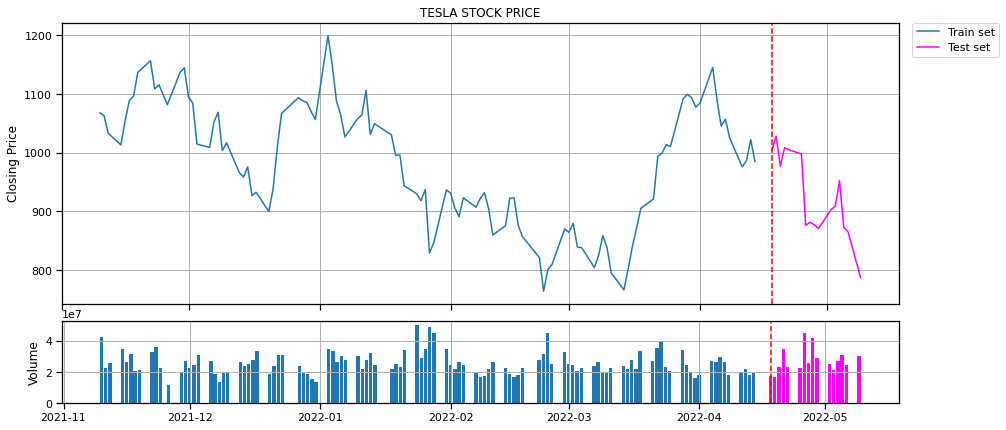

In [ ]:
plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(df_train.index, df_train.Close, label="Train set")
top.plot(df_test.index,df_test.Close, color="magenta", label="Test set")
bottom.bar(df_train.index, df_train.Volume)
bottom.bar(df_test.index, df_test.Volume, color="magenta")
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
 
# set the labels
top.axes.xaxis.set_ticklabels([])
top.axvline(df_test.index[0], color='red', linestyle='--')
bottom.axvline(df_test.index[0], color='red', linestyle='--')
top.set_title('TESLA STOCK PRICE')
top.grid(True)
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')
bottom.grid(True);

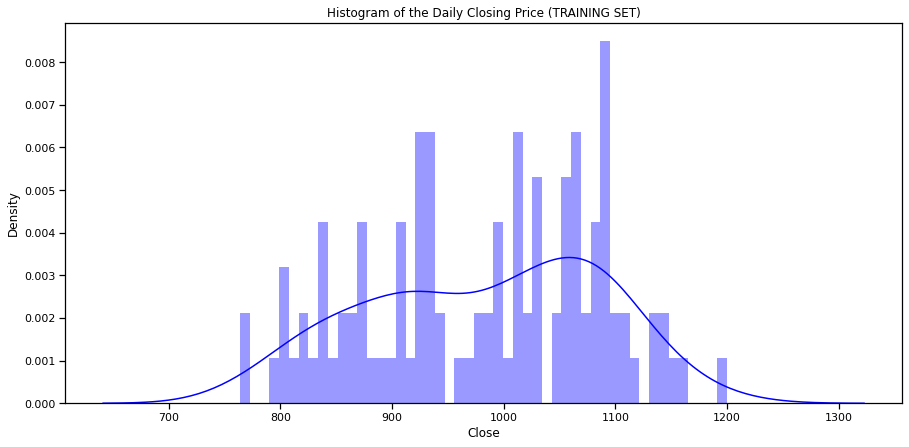

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Histogram of the Daily Closing Price (TRAINING SET)")
sns.distplot(df_train['Close'].dropna(), bins=50, color='blue');

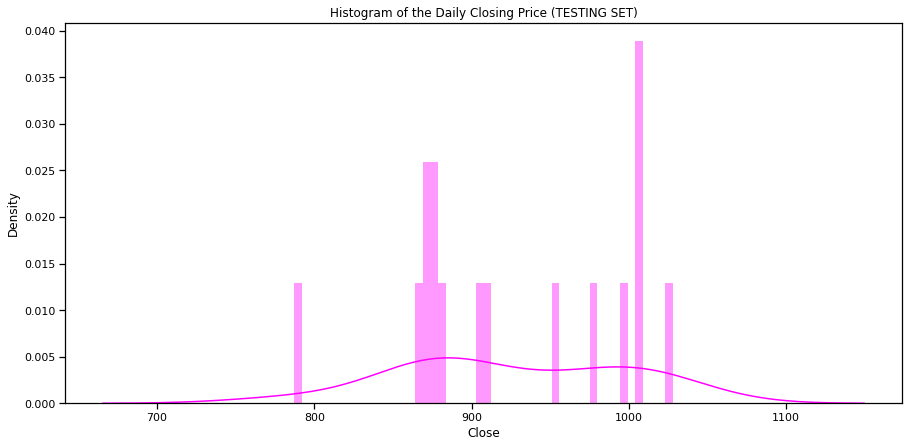

In [ ]:
plt.figure(figsize=(15,7))
plt.title("Histogram of the Daily Closing Price (TESTING SET)")
sns.distplot(df_test['Close'].dropna(), bins=50, color='magenta');

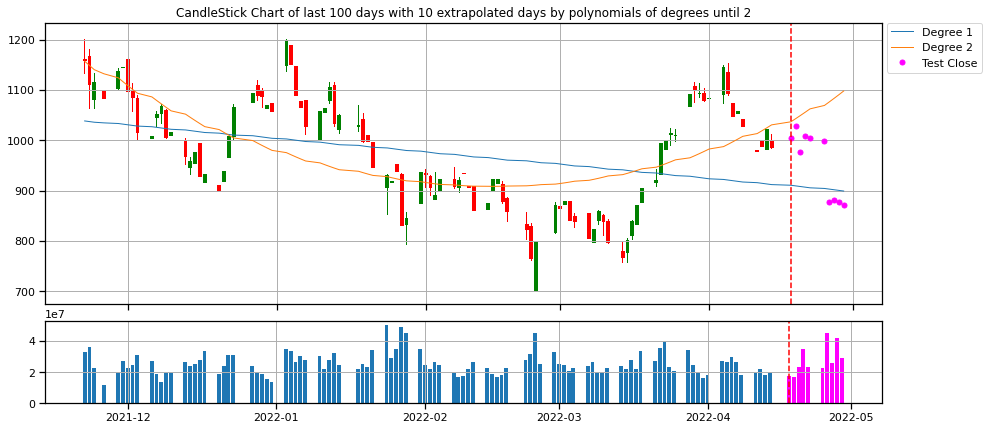

In [ ]:
d = 100 # days to plot
e = 10  # days to extrapolate
g = 2  # max degree of regression

width = .8
width2 = .1
col1 = 'green'
col2 = 'red'

LDAYS = df_train.tail(d)
up = LDAYS[LDAYS.Close>=LDAYS.Open]
down = LDAYS[LDAYS.Close<LDAYS.Open]
fut = df_test[df_test.index<=df_test.head(e).index[-1]]

xd = (LDAYS.index).append(df_test.head(e).index)

x = [x for x in range(d)]
p = {}
for i in range(g):
    z = np.polyfit(x, LDAYS.Close, i+1)
    p[i] = np.poly1d(z)
x = np.array(range(d+e))

plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.set_title(f"CandleStick Chart of last {d} days with {e} extrapolated days by polynomials of degrees until {g}")
top.axes.xaxis.set_ticklabels([])
for i in range(g):
    top.plot(xd, p[i](x), linewidth=1, label=f'Degree {i+1}')
top.plot(fut.index,fut.Close,  marker="o", markersize=5, color="magenta", linewidth=0, label="Test Close")
top.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
top.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
top.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)
top.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
top.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
top.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)
top.axvline(df_test.index[0], color='red', linestyle='--')
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
top.grid(True)

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(xd, np.append(LDAYS['Volume'].values,np.zeros(e))) 
bottom.bar(fut.index, fut.Volume, color="magenta") 
bottom.axvline(df_test.index[0], color='red', linestyle='--')

bottom.grid(True)
plt.show();

## Rolling polynomial regression
> Predict the test data with polynomial(linear) regression

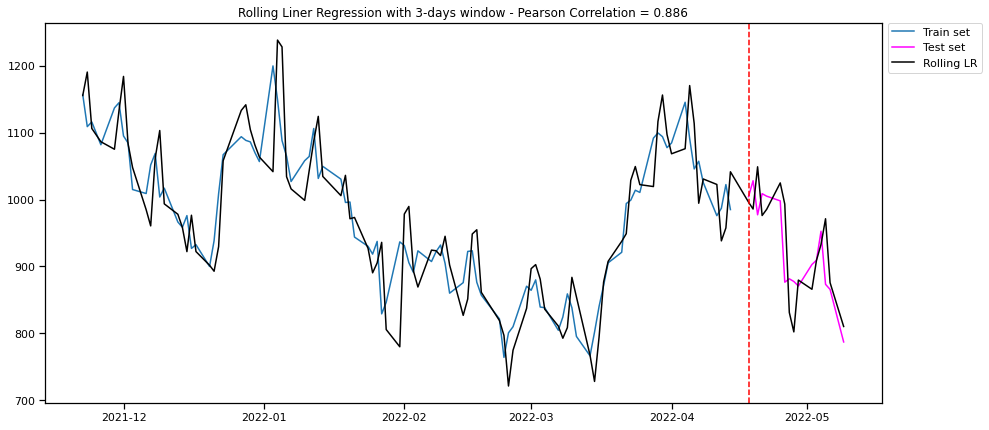

In [ ]:
d = 100 # days to plot
w = 3 # windows size

LDAYS = df_train.tail(d)
fut = pd.concat([df_train,df_test])
xd = (LDAYS.index).append(df_test.index)

fut['Cl_lr'] = fut.Close.rolling(window=w,closed="left").apply(lambda y: 
                   np.poly1d(np.polyfit(np.array(range(w)),y,1))(w),raw=True)

fut['Cl2'] = fut.Close.rolling(window=2,closed="left").apply(lambda y: 
                   np.poly1d(np.polyfit([0,1],y,1))(2),raw=True)

rho = np.corrcoef(fut.Close[-len(xd):],fut.Cl_lr[-len(xd):])

plt.figure(figsize=(15,7))
plt.plot(LDAYS.index, LDAYS.Close, label="Train set")
plt.plot(df_test.index,df_test.Close, color="magenta", label="Test set")
plt.plot(xd,fut.Cl_lr[-len(xd):], color="black", label="Rolling LR")
plt.axvline(df_test.index[0], color='red', linestyle='--')
plt.title(f"Rolling Liner Regression with {w}-days window - Pearson Correlation = {rho[0,1]:.3f}")
plt.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
plt.show();

### Result
> Correlation between prediction and actual values.

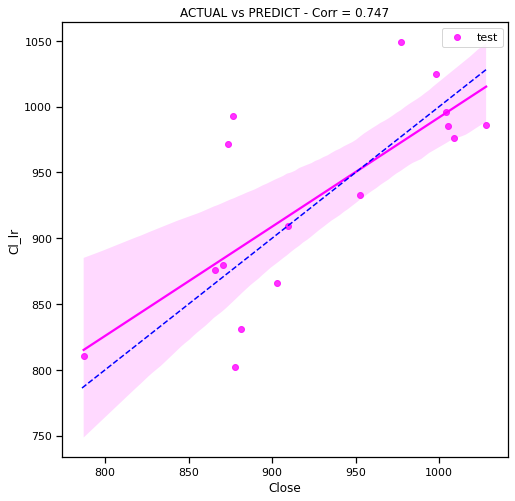

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=df_test.Close.min() - 1, stop=df_test.Close.max() + 1, num=100)
sns.regplot(x=df_test.Close, y=fut.Cl_lr[-len(df_test):], color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.set(title=f'ACTUAL vs PREDICT - Corr = {np.corrcoef(df_test.Close,fut.Cl_lr[-len(df_test):])[0,1]:.3f}');

## Prophet
> Predict with `Prophet`

In [ ]:
!pip install fbprophet

In [ ]:
from fbprophet import Prophet
from fbprophet.make_holidays import make_holidays_df

In [ ]:
year_list = [2021, 2022]
holidays = make_holidays_df(year_list=year_list, country='US')

ph_df = fut[["Close","Cl_lr",'Cl2']][w:len(df_train)].reset_index()
ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

m = Prophet(holidays=holidays,
            daily_seasonality=False,
            changepoint_prior_scale=0.015)
m.add_seasonality(name='monthly', period=20.5, fourier_order=5)
m.add_regressor('Cl_lr')
m.add_regressor('Cl2')
m.fit(ph_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Result

In [ ]:
# Predict Prices
future_prices = m.make_future_dataframe(periods=25, freq='d')
future_prices = future_prices[future_prices.ds.dt.dayofweek < 5]
future_prices = future_prices.set_index("ds").join(fut[['Cl_lr','Cl2']][w:], how='left')
future_prices = future_prices.reset_index().dropna()
forecast = m.predict(future_prices)
result = df_test[['Close']].join(forecast[['ds','yhat','yhat_lower','yhat_upper']].set_index("ds"),how='left')
result

,Close,yhat,yhat_lower,yhat_upper
Date,,,,
2022-04-18,1004.289978,982.743717,931.750489,1039.121938
2022-04-19,1028.150024,973.134598,921.476075,1025.684685
2022-04-20,977.200012,1011.955425,957.615539,1061.791325
2022-04-21,1008.780029,933.785768,877.310061,985.241962
2022-04-22,1005.049988,998.311921,941.637561,1051.107140
2022-04-25,998.020020,1003.953200,950.504436,1061.333532
2022-04-26,876.419983,975.154804,922.362684,1027.519808
2022-04-27,881.510010,842.644547,786.922762,896.546106
2022-04-28,877.510010,846.458587,796.080967,903.045550


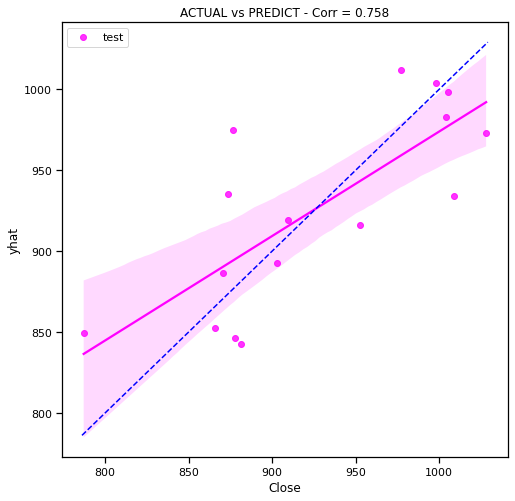

In [ ]:
rho = np.corrcoef(result.Close,result.yhat)
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=df_test.Close.min() - 1, stop=df_test.Close.max() + 1, num=100)
sns.regplot(x=result.Close, y=result.yhat, color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.legend()
ax.set(title=f'ACTUAL vs PREDICT - Corr = {np.corrcoef(result.Close,result.yhat)[0,1]:.3f}');


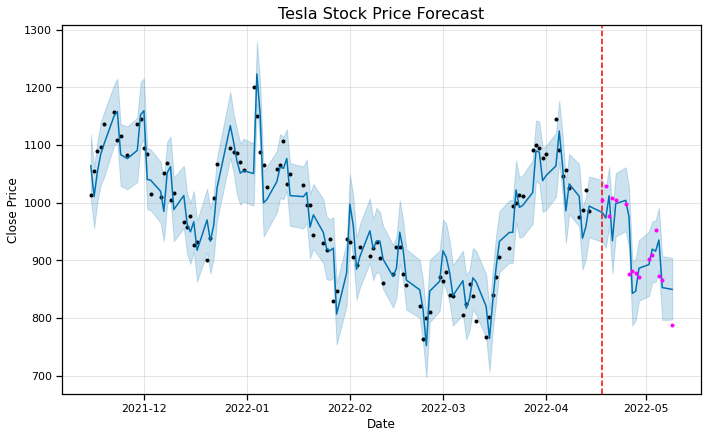

In [ ]:
fig = m.plot(forecast)
plt.title(f"Tesla Stock Price Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.axvline(df_test.index[0], color='red', linestyle='--')
plt.plot(df_test.index, df_test.Close,  marker="o", markersize=3, color="magenta", linewidth=0, label="Test Close")
plt.show()

### Evaluate components

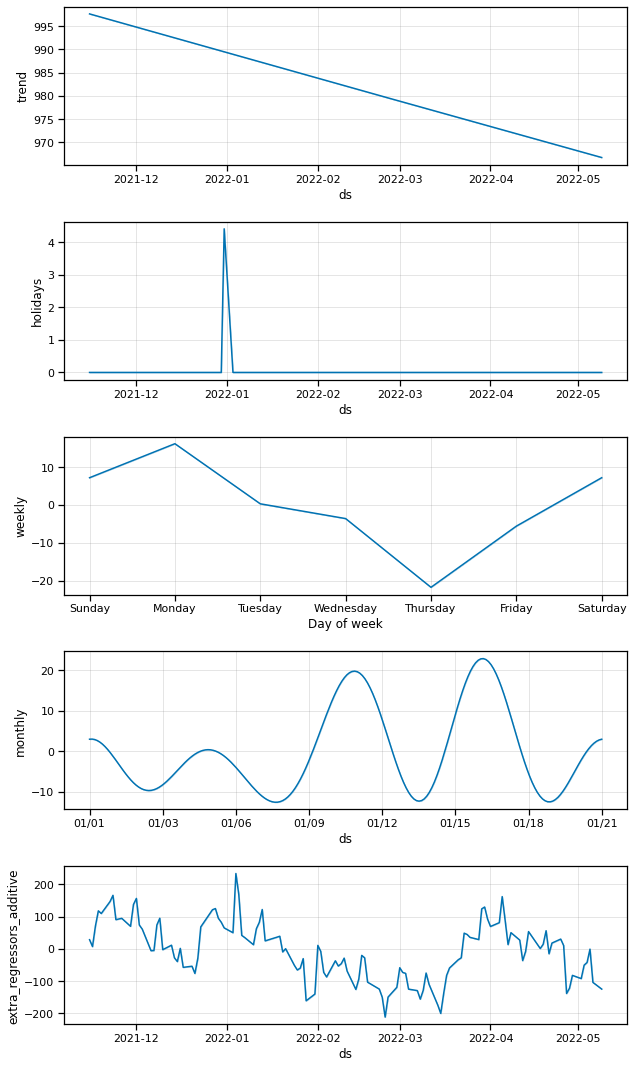

In [ ]:
fig2 = m.plot_components(forecast)
plt.show()

## Conclusion
> In conclusion, using `Prophet` is more accurate when predicting periodic data. However, using rolling regression also get good performance. Therefore, we might improve the algorithm by using different regression model with the same rolling strategy.

**Wish you guys like this content! Thanks for reading! Peace!!!**